In [1]:
import sys
sys.path.append("..")  # Adds the parent directory to the sys.path

from utitlity_functions import *
import numpy as np
from confectionery import Confectionery
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from cluster_half_shelfs_alpha import Half_shelf_cluster
import scienceplots
import cv2 as cv
from matplotlib import cm
from scipy.stats import norm
from cluster_to_edge_pixel import contour_edge
np.random.seed(137)

# load data

In [2]:
im_stream=np.load("/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/plot_folder/data/im_stream_obj_0.npy")
obj_0=np.load("/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/plot_folder/data/obj_0.npy")
r_effective=11
koppenrath=Confectionery()
half_shelf_cluster=Half_shelf_cluster(obj_0, im_stream, confectionery=koppenrath,cut_radius=r_effective)
half_shelf_cluster.load_data_from_np_array(
np.load("/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/plot_folder/data/obj_0_all_grayscale_on_radius_11.npy")
)


# Show contour tracking of different clustered images

In [3]:
start_frame=0
step=4
step_size=12
end_frame=start_frame+step_size*step+1

half_shelf_cluster.train_gmm()
gmm=half_shelf_cluster.gmm
priors_gmm = gmm.weights_
means_gmm = gmm.means_.reshape((-1))
sigma_gmm = np.sqrt(gmm.covariances_.reshape((-1)))
# sort gaussian
idx = np.argsort(means_gmm)
means_gmm=means_gmm[idx]
priors_gmm=priors_gmm[idx]
sigma_gmm=sigma_gmm[idx]

a=5

clustered_images=[]
edge_pixels=[]
object_images=[]
flat_data=[]
labels=[]
for i in range(start_frame,end_frame,step_size):
    im=cv.imread(im_stream[i], cv.IMREAD_GRAYSCALE)
    x=obj_0[i,1]
    y=obj_0[i,2]
    r=round(obj_0[i,3])
    object_indeces=np.s_[round(y-r)-a:round(y+r)+a+1,round(x-r)-a:round(x+r)+a+1]
    im_obj=im[object_indeces]
    object_images.append(im_obj)
    M=koppenrath.sell_cake(r_effective,im_obj.shape[0],im_obj.shape[0])
    flat_data.append(im_obj[M])
    label=gmm.predict(im_obj[M].reshape((-1,1)))
    label=idx[label]
    labels.append(label)
    clustered_image=np.zeros_like(im_obj)
    clustered_image[M]=label+1
    clustered_images.append(clustered_image)
    
    contour_object=contour_edge(clustered_image, cut_radius=r_effective, confectionery=koppenrath)
    contour_object.compute_edges()
    contour_object.reduce_edges()
    edge_pixels.append(contour_object.edge_pixels)


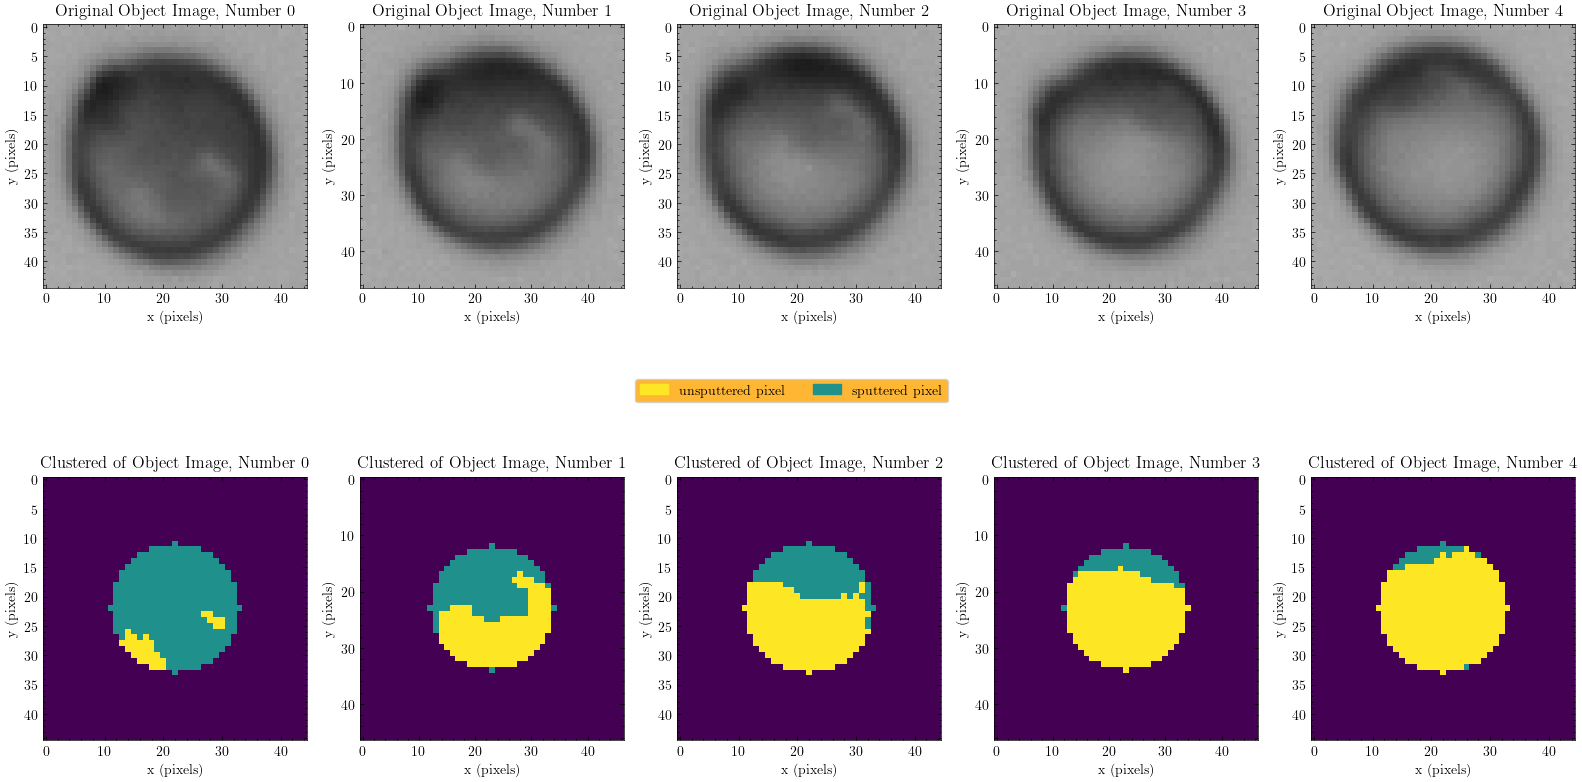

In [4]:
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [16, 10]
    fig, ax = plt.subplots(2,5)
    for i in range(len(clustered_images)):
        ax[0,i].set_title('Original Object Image, Number ' + str(i))
        ax[0,i].imshow(object_images[i], cmap="gray", vmin=0, vmax=255)
        ax[0,i].set_xlabel("x (pixels)")
        ax[0,i].set_ylabel("y (pixels)")

        ax[1,i].set_title('Clustered of Object Image, Number ' + str(i))
        ax[1,i].imshow(clustered_images[i],vmin=0, vmax=2)
        ax[1,i].set_xlabel("x (pixels)")
        ax[1,i].set_ylabel("y (pixels)")
    yellow_patch = mpatches.Patch(color=(253/255,231/255,37/255), label='unsputtered pixel')
    green_patch = mpatches.Patch(color=(33/255,145/255,140/255), label='sputtered pixel')
    fig.tight_layout() 

    fig.legend(loc="center", handles=[yellow_patch, green_patch],frameon=True, facecolor="orange", ncol=3)
    plt.show()

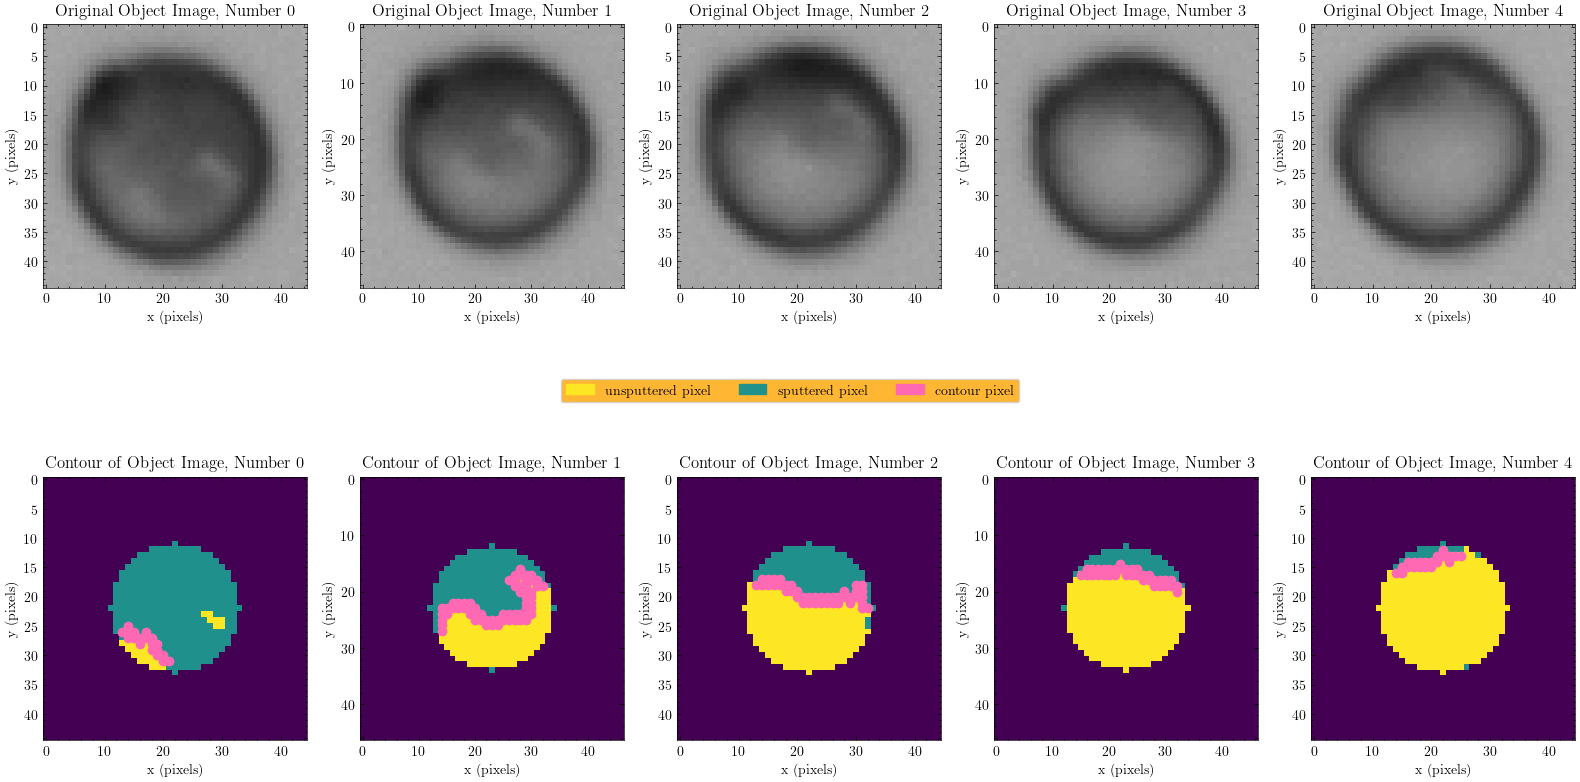

In [5]:
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [16, 10]
    fig, ax = plt.subplots(2,5)
    for i in range(len(clustered_images)):
        ax[0,i].set_title('Original Object Image, Number ' + str(i))
        ax[0,i].imshow(object_images[i], cmap="gray", vmin=0, vmax=255)
        ax[0,i].set_xlabel("x (pixels)")
        ax[0,i].set_ylabel("y (pixels)")

        ax[1,i].set_title('Contour of Object Image, Number ' + str(i))
        ax[1,i].imshow(clustered_images[i],vmin=0, vmax=2)
        ax[1,i].scatter(edge_pixels[i][:,0],edge_pixels[i][:,1],color = 'hotpink')
        ax[1,i].set_xlabel("x (pixels)")
        ax[1,i].set_ylabel("y (pixels)")
    yellow_patch = mpatches.Patch(color=(253/255,231/255,37/255), label='unsputtered pixel')
    green_patch = mpatches.Patch(color=(33/255,145/255,140/255), label='sputtered pixel')
    hotpink_patch = mpatches.Patch(color="hotpink", label='contour pixel')
    fig.tight_layout() 

    fig.legend(loc="center", handles=[yellow_patch, green_patch, hotpink_patch],frameon=True, facecolor="orange", ncol=3)
    plt.show()